## Image classification with Convolutional Neural Networks

Welcome to the first week of the second deep learning certificate! We're going to use convolutional neural networks (CNNs) to allow our computer to see - something that is only possible thanks to deep learning.

In [1]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

Here we import the libraries we need. We'll learn about what each does during the course.

In [2]:
# This file contains all the main external libs we'll use
from fastai.imports import *

In [3]:
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

In [4]:
PATH = "data/content/"

In [5]:
sz=336

## First look at pictures

Our library will assume that you have *train* and *valid* directories. It also assumes that each dir will have subdirs for each class you wish to recognize (in this case, 'cats' and 'dogs').

In [6]:
!ls {PATH}

models	tmp  train  valid


In [7]:
!ls {PATH}valid

animal	botanical  bottle  car	food  human


In [8]:
files = !ls {PATH}valid/food | head
files

['00e4f912938653.5626f32d406fd.jpg',
 '01d66e4661967.5634c9a34510a.jpg',
 '02c6ae11782839.560fd3073009b.jpg',
 '02d56028537689.56e301a95e696.jpg',
 '03d3f326837981.5635b3583d443.jpg',
 '05b4dd48267245.589d80692c4d1.jpg',
 '0a098346403369.5852bd04f21f4.jpg',
 '0a216041865073.57d19d64bd6cc.png',
 '0a68aa15352867.5628fe9eef8e8.jpg',
 '0aae8333146015.56a140e414731.jpg']

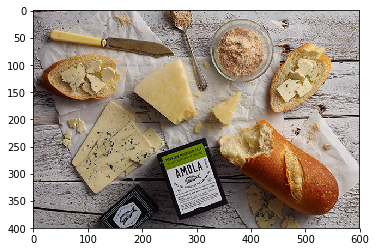

In [9]:
img = plt.imread(f'{PATH}valid/food/{files[0]}')
plt.imshow(img);

Here is how the raw data looks like

In [10]:
img.shape

(400, 600, 3)

In [11]:
img[:4,:4]

array([[[173, 170, 177],
        [128, 125, 132],
        [ 59,  54,  60],
        [ 52,  47,  51]],

       [[170, 151, 171],
        [110,  92, 108],
        [ 82,  65,  73],
        [ 58,  40,  40]],

       [[ 70,  61,  56],
        [ 66,  56,  54],
        [ 87,  77,  78],
        [ 65,  53,  57]],

       [[  4,   0,   5],
        [  6,   0,   2],
        [ 12,   3,   4],
        [ 12,   5,   0]]], dtype=uint8)

## Our first model: quick start

In [12]:
# Uncomment the below if you need to reset your precomputed activations
!rm -rf {PATH}tmp

In [13]:
arch=resnet152
data = ImageClassifierData.from_paths(PATH, tfms=tfms_from_model(arch, sz))
learn = ConvLearner.pretrained(arch, data, precompute=True)
learn.fit(0.01, 3)

100%|██████████| 18/18 [00:40<00:00,  2.23s/it]


HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

[ 0.       0.69386  0.43242  0.84995]                      
[ 1.       0.473    0.40285  0.84883]                      
[ 2.       0.37056  0.41922  0.85491]                      



How good is this model? Well, as we mentioned, prior to this competition, the state of the art was 80% accuracy. But the competition resulted in a huge jump to 98.9% accuracy, with the author of a popular deep learning library winning the competition. Extraordinarily, less than 4 years later, we can now beat that result in seconds! Even last year in this same course, our initial model had 98.3% accuracy, which is nearly double the error we're getting just a year later, and that took around 10 minutes to compute.

In [14]:
# This is the label for a val data
data.val_y

array([0, 0, 0, ..., 5, 5, 5])

In [15]:
# from here we know that 'cats' is label 0 and 'dogs' is label 1.
data.classes

['animal', 'botanical', 'bottle', 'car', 'food', 'human']

In [16]:
# this gives prediction for validation set. Predictions are in log scale
log_preds = learn.predict()
log_preds.shape

(1116, 6)

In [17]:
log_preds[:10]

array([[ -0.01766, -11.2631 ,  -7.53418,  -6.50996,  -6.65681,  -4.2555 ],
       [ -0.00557,  -5.5916 ,  -9.3377 , -10.56468,  -7.05621,  -7.06573],
       [ -0.03194,  -3.99516,  -8.45282,  -5.26885,  -5.88044,  -5.32314],
       [ -0.6315 ,  -1.96759,  -3.36277,  -1.98697,  -2.28235,  -2.90739],
       [ -0.40417, -10.01407,  -9.34158,  -9.44462,  -7.76512,  -1.10311],
       [ -0.52215,  -2.83297,  -3.77759,  -4.81477,  -1.45087,  -2.49416],
       [ -1.1815 ,  -5.72251,  -4.32629,  -4.603  ,  -2.3636 ,  -0.55759],
       [ -0.15515,  -2.35134,  -6.99108,  -7.19351,  -7.20712,  -3.07783],
       [ -0.11209,  -4.41743,  -4.76859,  -6.73837,  -2.79907,  -3.75395],
       [ -0.01509,  -4.42647,  -8.73356,  -7.64055,  -7.04767,  -6.49641]], dtype=float32)

## Choosing a learning rate

In [31]:
learn = ConvLearner.pretrained(arch, data, precompute=True)

In [32]:
lrf=learn.lr_find()

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 56%|█████▌    | 23/41 [00:00<00:00, 28.31it/s, loss=7.96]


Our `learn` object contains an attribute `sched` that contains our learning rate scheduler, and has some convenient plotting functionality including this one:

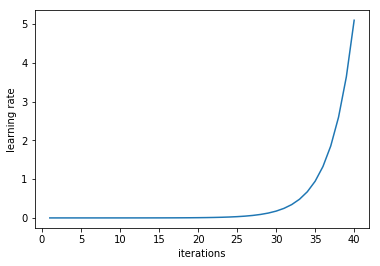

In [33]:
learn.sched.plot_lr()

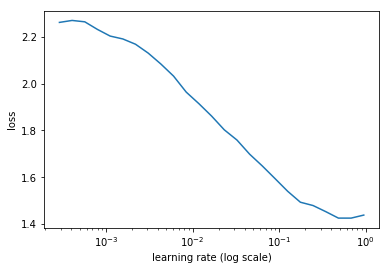

In [34]:
learn.sched.plot()

## Improving our model

### Data augmentation

In [35]:
arch=resnet34

In [36]:
tfms = tfms_from_model(resnet34, sz, aug_tfms=transforms_side_on, max_zoom=1.1)

In [37]:
def get_augs():
    data = ImageClassifierData.from_paths(PATH, bs=2, tfms=tfms, num_workers=1)
    x,_ = next(iter(data.aug_dl))
    return data.trn_ds.denorm(x)[1]

In [38]:
ims = np.stack([get_augs() for i in range(6)])

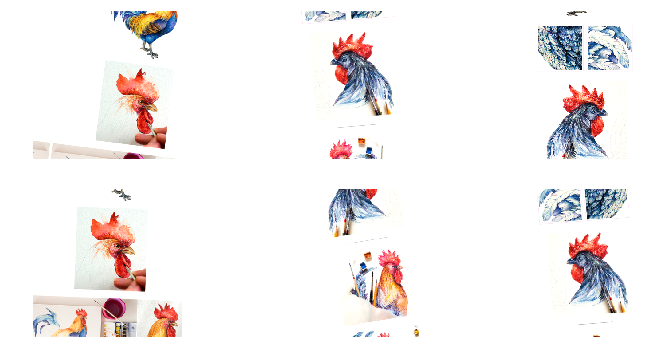

In [39]:
plots(ims, rows=2)

In [40]:
data = ImageClassifierData.from_paths(PATH, tfms=tfms)
learn = ConvLearner.pretrained(arch, data, precompute=True)

100%|██████████| 18/18 [00:13<00:00,  1.38it/s]


In [41]:
learn.fit(1e-1, 3)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

[ 0.       1.07088  0.77883  0.78646]                     
[ 1.       0.83396  0.53395  0.8182 ]                      
[ 2.       0.62297  0.63649  0.81734]                      



In [42]:
learn.precompute=False

In [43]:
learn.fit(1e-1, 3, cycle_len=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

[ 0.       0.47446  0.4664   0.82775]                      
[ 1.       0.44531  0.4454   0.83693]                      
[ 2.       0.41741  0.44089  0.83929]                      



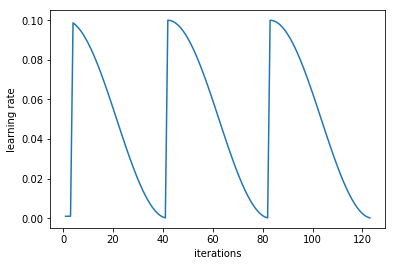

In [44]:
learn.sched.plot_lr()

In [45]:
learn.save('336_lastlayer')

In [46]:
learn.load('336_lastlayer')

### Fine-tuning and differential learning rate annealing

Now that we have a good final layer trained, we can try fine-tuning the other layers. To tell the learner that we want to unfreeze the remaining layers, just call (surprise surprise!) `unfreeze()`.

In [47]:
learn.unfreeze()

In [48]:
lr=np.array([1e-4,1e-3,1e-2])

In [49]:
learn.fit(lr, 3, cycle_len=2, cycle_mult=3)

HBox(children=(IntProgress(value=0, description='Epoch', max=26), HTML(value='')))

[ 0.       0.45793  0.40206  0.85975]                      
[ 1.       0.36872  0.3912   0.86409]                      
[ 2.       0.31991  0.37559  0.86756]                      
[ 3.       0.27731  0.35968  0.87686]                      
[ 4.       0.23227  0.3613   0.8786 ]                      
[ 5.       0.18847  0.3582   0.87512]                      
[ 6.       0.16949  0.35572  0.87252]                      
[ 7.       0.16441  0.36165  0.87773]                      
[ 8.       0.16188  0.353    0.87686]                      
[ 9.       0.14345  0.35285  0.88207]                      
[ 10.        0.12832   0.35431   0.87537]                  
[ 11.        0.12003   0.33915   0.88579]                  
[ 12.        0.10345   0.38548   0.87339]                  
[ 13.        0.09189   0.36965   0.87798]                   
[ 14.        0.07961   0.37934   0.87884]                   
[ 15.        0.07889   0.38613   0.87971]                   
[ 16.        0.0765    0.37072   0.87

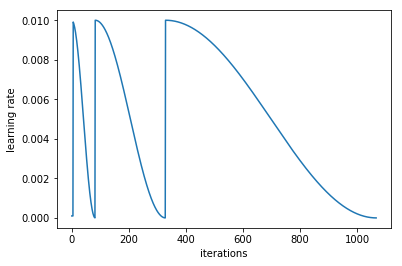

In [50]:
learn.sched.plot_lr()

In [51]:
learn.save('336_all')

In [52]:
learn.load('336_all')

In [53]:
log_preds,y = learn.TTA()
probs = np.mean(np.exp(log_preds),0)

In [54]:
accuracy(probs, y)

0.90322580645161288

I generally see about a 10-20% reduction in error on this dataset when using TTA at this point, which is an amazing result for such a quick and easy technique!

## Analyzing results

### Confusion matrix 

In [55]:
preds = np.argmax(probs, axis=1)
probs = probs[:,1]

A common way to analyze the result of a classification model is to use a [confusion matrix](http://www.dataschool.io/simple-guide-to-confusion-matrix-terminology/). Scikit-learn has a convenient function we can use for this purpose:

In [56]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y, preds)

We can just print out the confusion matrix, or we can show a graphical view (which is mainly useful for dependents with a larger number of categories).

[[160   8   0   0   4   7]
 [  9 219   0   0   7   0]
 [  0   2  85   0   6   0]
 [  0   0   0 135   0   0]
 [ 16  18   6   0 148   1]
 [ 20   1   0   0   3 261]]


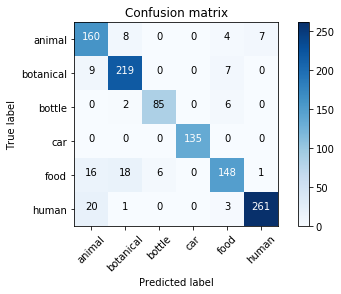

In [57]:
plot_confusion_matrix(cm, data.classes)